# <b> Convex Optimization Homework 3 </b>
Name: Imane SI SALAH


---




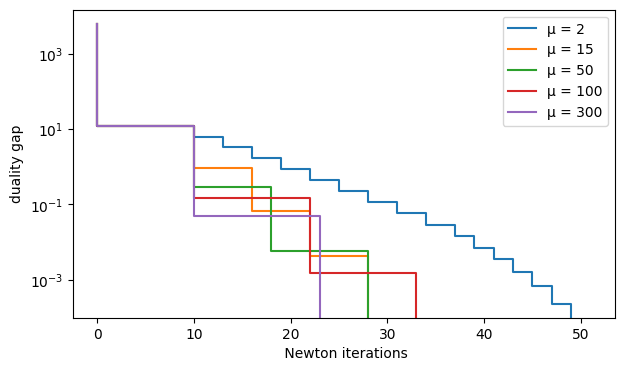

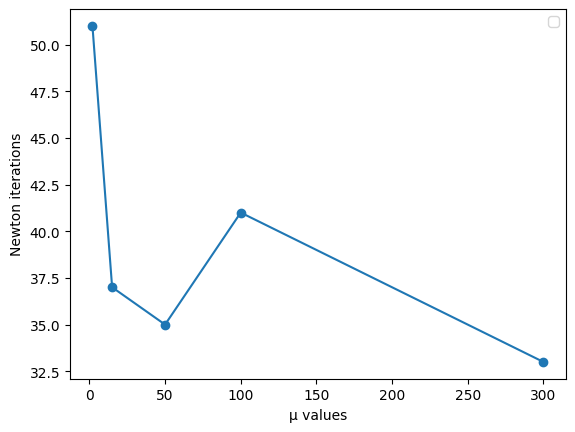

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from sklearn.datasets import make_regression


def f0(Q, p, v):
    return np.dot(np.dot(v.T,Q),v) + np.dot(p.T,v)

# Objective function
def f(Q, p, A, b, t, v):

    if np.min(b - A.dot(v)) <= 0:
        print(b - A.dot(v))
        return None
    else:
        return t * (v.T.dot(Q).dot(v) + p.T.dot(v)) - np.sum(np.log(b - A.dot(v)))


# Gradient
def grad(Q, p, A, b, t, v):
    """Compute the gradient of the objective function."""
    return t * (2 * Q.dot(v) + p) + A.T.dot(1 / (b - A.dot(v)))

# Hessian
def hess(Q, p, A, b, t, v):
    """Compute the Hessian of the objective function."""
    return t * 2 * Q + (A.T.dot(np.diag((1 / ((b - A.dot(v)) ** 2)).reshape(-1)))).dot(A)


def backtracking(Q, p, A, b, t, v, delta_v, alpha, beta):
  rate_t=1
  while True:
    delta_f= grad(Q, p, A, b, t, v).T
    if not ((b - A.dot(v + rate_t * delta_v)) > 0).all() or (
        f(Q, p, A, b, t, v + rate_t * delta_v) > f(Q, p, A, b, t, v) + alpha * rate_t * grad(Q, p, A, b, t, v).T.dot(delta_v)):
      rate_t= beta*rate_t
    else:
      break
  return rate_t


def centering_step(Q, p, A, b, t, v_start, eps):
  #apply newton method to optimize f
  v_init= [v_start]
  newt_iter=0

  while True:
    newt_step= -inv(hess(Q, p, A, b, t, v_start)).dot(grad(Q, p, A, b, t, v_start))
    decrement= -grad(Q, p, A, b, t, v_start).T.dot(-inv(hess(Q, p, A, b, t, v_start)).dot(grad(Q, p, A, b, t, v_start)))
    if decrement/2<eps:
      break
    else:
      rate_t= backtracking(Q, p, A, b, t, v_start, newt_step, 0.01, 0.5)
      v_start= v_start+ rate_t* newt_step
      v_init.append(v_start)
      newt_iter+=1
  return v_init[-1],  newt_iter


def barrier_method(Q, p, A, b, t_init, v_start, mu, eps):
  #now apply the barrier method
  t=t_init
  result=[v_start]
  inner_iter=[0]
  outer_iter=[0]
  m= A.shape[0] #nb of constsaints
  while True:
    v_start, next_count= centering_step(Q, p, A, b, t, v_start,0.00001)
    inner_iter.append(inner_iter[-1]+ next_count)
    outer_iter.append(outer_iter[-1]+1)
    result.append(v_start)
    if m/t<eps:
      break
    else:
      t= mu*t
  return result, inner_iter, outer_iter

# Data generation
nb_samples = 200
nb_features = 20

lb = 10
np.random.seed(1)
X,y= make_regression(n_samples=nb_samples, n_features=nb_features, noise=1)
y = y.reshape((-1, 1))

Q = 0.5 * np.eye(nb_samples)
p = -y
A = np.vstack((X.T, -X.T))
b = lb * np.ones((2 * nb_features, 1))
v_start = np.zeros((nb_samples, 1))
t=1
eps = 0.001


mu_values= [2, 15, 50, 100, 300]
nb_iters=[]

# Visualization
plt.figure(figsize=(7, 4))

for mu in mu_values:
    v_sequence, inner_iter, outer_iter = barrier_method(Q, p, A, b, 1, v_start, mu, 0.001)
    v_last = v_sequence[-1]
    gap = [(v_start.T.dot(Q).dot(v_start) + p.T.dot(v_start))[0, 0] - (v_last.T.dot(Q).dot(v_last) + p.T.dot(v_last))[0, 0] for v_start in v_sequence]
    plt.step(inner_iter, gap, label="µ = " + str(mu))
    nb_iters.append(inner_iter[-1])

plt.legend(loc="upper right")
plt.semilogy()
plt.xlabel(" Newton iterations")
plt.ylabel("duality gap")
plt.savefig("plot.eps")
plt.show()

plt.figure()
plt.plot(mu_values, nb_iters, 'o-')
plt.xlabel('µ values')
plt.ylabel('Newton iterations')
plt.legend()
plt.show()
